In [1]:


import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from numpy.random import randn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option( "display.max_columns", None)

data  = pd.read_csv("credit.csv") 

# How big is the training dataset?
a look at the data set

In [3]:
print("The  dataset has {} entires or columns.".format(data.shape))

The  dataset has (5960, 13) entires or columns.


# lets see each sample of our target label

In [4]:
data_sample1 = data.loc[data.BAD==1].sample(frac=0.1, replace=False)
print('label 1 sample size:', str(data_sample1.shape[0]))
data_sample0 = data.loc[data.BAD==0].sample(frac=0.1, replace=False)
print('label 0 sample size:', str(data_sample0.shape[0]))
sample = pd.concat([data_sample1, data_sample0], axis=0)

label 1 sample size: 119
label 0 sample size: 477


# let see the numbers of categorical features and numerical features

In [5]:
categorical_list = []
numerical_list = []
for i in data.columns.tolist():
    if data[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 2
Number of numerical features: 11


In [6]:
data.sample(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5791,0,47600,NaN,86652.0,HomeImp,Office,7.0,0.0,0.0,304.058102,0.0,13.0,31.571295
3837,0,20100,70491.0,100797.0,DebtCon,Other,NaN,2.0,0.0,247.037272,2.0,14.0,40.272149
3334,1,17700,58016.0,76416.0,DebtCon,Office,4.0,0.0,0.0,28.011492,5.0,10.0,41.463373
2839,1,15800,42504.0,64847.0,HomeImp,Other,NaN,0.0,0.0,120.738013,2.0,18.0,36.834458
1282,0,10300,59340.0,84708.0,HomeImp,Other,13.0,0.0,0.0,222.364889,1.0,36.0,34.925984


In [7]:
data.BAD.value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

# data cleaning

In [8]:
#lets find the count of null values

data.isnull().sum().sort_values(ascending=False)

DEBTINC    1267
DEROG       708
DELINQ      580
MORTDUE     518
YOJ         515
NINQ        510
CLAGE       308
JOB         279
REASON      252
CLNO        222
VALUE       112
LOAN          0
BAD           0
dtype: int64

In [9]:
#lets put all the variables with missing values and their percentage in a table

def missing_values_table(df):
    missing_values= df.isnull().sum()
    
    # Percentage of missing values
    
    missing_percentage = 100 *df.isnull().sum() /len(df)
    
    missing_values_table = pd.concat([missing_values, missing_percentage],axis=1)
    
    missing_val_table_columns = missing_values_table.rename(columns={0 : 'Missing Values', 1 : '% of Missing Values'})
    
    missing_val_table_columns = missing_val_table_columns[
            missing_val_table_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)
    
    return missing_val_table_columns



# Lets see the missing value table
missing_values_table(data)

,Missing Values,% of Missing Values
DEBTINC,1267,21.3
DEROG,708,11.9
DELINQ,580,9.7
MORTDUE,518,8.7
YOJ,515,8.6
NINQ,510,8.6
CLAGE,308,5.2
JOB,279,4.7
REASON,252,4.2
CLNO,222,3.7


In [10]:
(missing_values_table(data)).head(49)

,Missing Values,% of Missing Values
DEBTINC,1267,21.3
DEROG,708,11.9
DELINQ,580,9.7
MORTDUE,518,8.7
YOJ,515,8.6
NINQ,510,8.6
CLAGE,308,5.2
JOB,279,4.7
REASON,252,4.2
CLNO,222,3.7


# lets encode our categorical data

In [11]:
credit_encode = data
encoder=LabelEncoder()

In [12]:
credit_encode['REASON'] = encoder.fit_transform(credit_encode['REASON'])
credit_encode['JOB'] = encoder.fit_transform(credit_encode['JOB'])

In [13]:
data.fillna((0), inplace=True)

In [14]:
data.shape

(5960, 13)

In [15]:
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,1,2,10.5,0.0,0.0,94.366667,1.0,9.0,0.0
1,1,1300,70053.0,68400.0,1,2,7.0,0.0,2.0,121.833333,0.0,14.0,0.0
2,1,1500,13500.0,16700.0,1,2,4.0,0.0,0.0,149.466667,1.0,10.0,0.0
3,1,1500,0.0,0.0,2,6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0,1700,97800.0,112000.0,1,1,3.0,0.0,0.0,93.333333,0.0,14.0,0.0


# Feature Selection
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Three benefits of performing feature selection before modeling your data are:

Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise. Improves Accuracy: Less misleading data means modeling accuracy improves. Reduces Training Time: Less data means that algorithms train faster.

In [16]:
X = data.drop('BAD', axis = 1)
y = data.BAD

In [17]:
X.shape, y.shape

((5960, 12), (5960,))

# Univariate Feature Selection
Univariate feature selection selects the best features by running univariate statistical tests like chi-squared test, F-1 test, and mutual information methods.

In [18]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [19]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [20]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   features         Score
2     VALUE  1.596433e+06
1   MORTDUE  3.674824e+05
0      LOAN  2.268599e+05
11  DEBTINC  9.801855e+03
8     CLAGE  7.914209e+03
7    DELINQ  2.054126e+03
6     DEROG  1.233862e+03
9      NINQ  4.698772e+02
5       YOJ  5.762630e+01
10     CLNO  4.071969e+00


# Univariate Analysis (features and target 'BAD')
Features distributions

In [22]:
target = 'BAD'
features_list = list(data.columns)
features_list.remove(target)

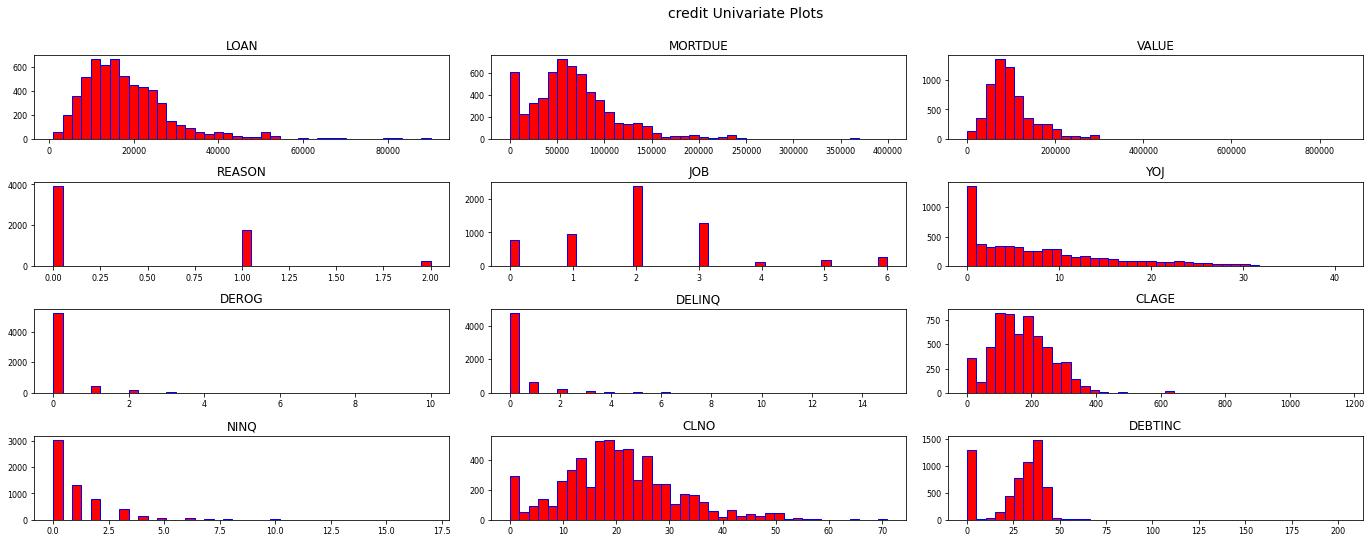

In [23]:
data[features_list].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('credit Univariate Plots', x=0.65, y=1.25, fontsize=14);  

# Bivariate Features vs Target
exemple : 'DELINQ' vs 'bad' plot

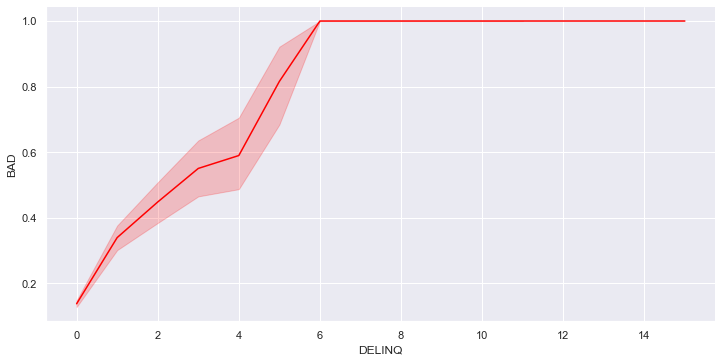

In [114]:
sns.set()
sns.relplot(data=data, x='DELINQ', y=target, kind='line', height=5, aspect=2, color='red'); 

# Recursive Feature Elimination (RFE)
Recursive Feature Elimination (RFE) recursively selects important subsets of features based on built-in attributes like coefficients or feature importance of a given estimator. Hence RFE heavily depends on which estimator we are using

In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [25]:
def print_best_worst (scores):
    scores = sorted(scores, reverse = True)
    
    print("The 5 best features selected by this method are :")
    for i in range(5):
        print(scores[i][1])
    
    print ("The 5 worst features selected by this method are :")
    for i in range(5):
        print(scores[len(scores)-1-i][1])

In [26]:
clf = RandomForestClassifier(n_estimators = 50, max_depth = 4)

scores = []
num_features = len(X.columns)
for i in range(num_features):
    col = X.columns[i]
    score = np.mean(cross_val_score(clf, X[col].values.reshape(-1,1), y, cv=10))
    scores.append((int(score*100), col))

print(sorted(scores, reverse = True))

[(86, 'DEBTINC'), (81, 'VALUE'), (81, 'DELINQ'), (80, 'YOJ'), (80, 'REASON'), (80, 'MORTDUE'), (80, 'JOB'), (80, 'DEROG'), (80, 'CLNO'), (79, 'NINQ'), (79, 'CLAGE'), (24, 'LOAN')]


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
rfe = RFE(LogisticRegression(), n_features_to_select=1)
rfe.fit(X,y)

In [28]:
scores = []
for i in range(num_features):
    scores.append((rfe.ranking_[i],X.columns[i]))
    
print_best_worst(scores)

The 5 best features selected by this method are :
VALUE
MORTDUE
LOAN
CLNO
CLAGE
The 5 worst features selected by this method are :
DELINQ
DEROG
REASON
NINQ
DEBTINC


# Feature Importance¶
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

In [29]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [30]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers


[0.06981094 0.06837086 0.09160988 0.0305963  0.05455802 0.06281718
 0.05652207 0.09605059 0.08322012 0.0535382  0.07536738 0.25753846]


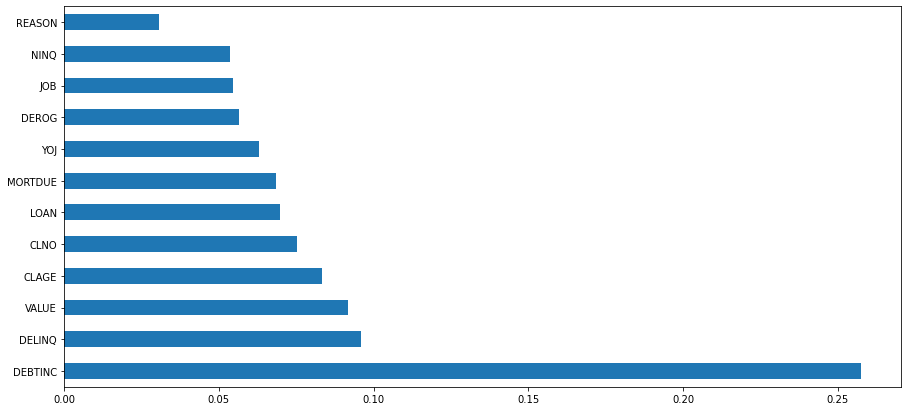

In [31]:
#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(15,7))

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

# let try Random Forest Feature Importance

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X,y)

RandomForestClassifier()

In [33]:
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers


[0.07489344 0.07024521 0.11165107 0.01605916 0.03480002 0.05635323
 0.04286213 0.07838398 0.09462404 0.03502687 0.06524824 0.31985262]


In [34]:
scores = []
for i in range(num_features):
    scores.append((clf.feature_importances_[i],X.columns[i]))
        
print_best_worst(scores)

The 5 best features selected by this method are :
DEBTINC
VALUE
CLAGE
DELINQ
LOAN
The 5 worst features selected by this method are :
REASON
JOB
NINQ
DEROG
YOJ


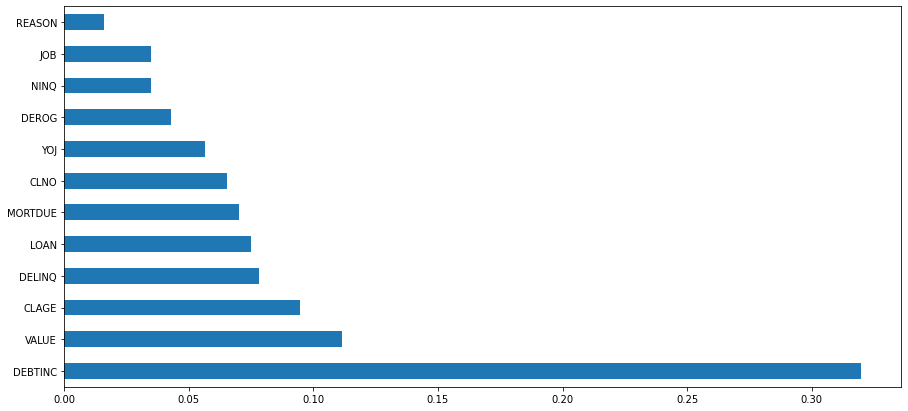

In [35]:
#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(15,7))

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

# XGBoost Feature Importance
The XGBoost library provides a built-in function to plot features ordered by their importance.

The function is called plot_importance()

In [38]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
model.fit(X, y)
score = model.score(X, y)

[13:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


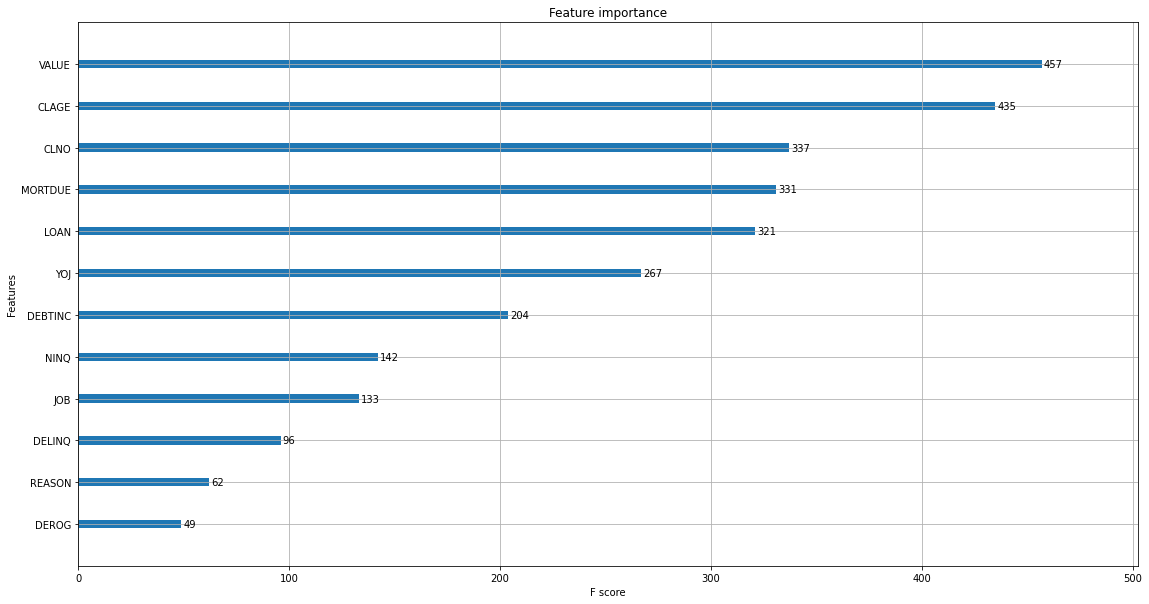

In [41]:
from xgboost import plot_importance
from matplotlib import pyplot


plt.rcParams['figure.figsize'] = (19, 10)

plot_importance(model)

pyplot.show()

In [42]:
#the most important feature according to tree classifier  is DEPTIC, while the list important one is reason
#the most important feature according to Random Forest  is DEPTIC too, while the list important one is also reason
#meanwhile, the most important feature according to XGBoost  is VALUE, while the list important one is DEROG


# Correlation Matrix with Heatmap
Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.



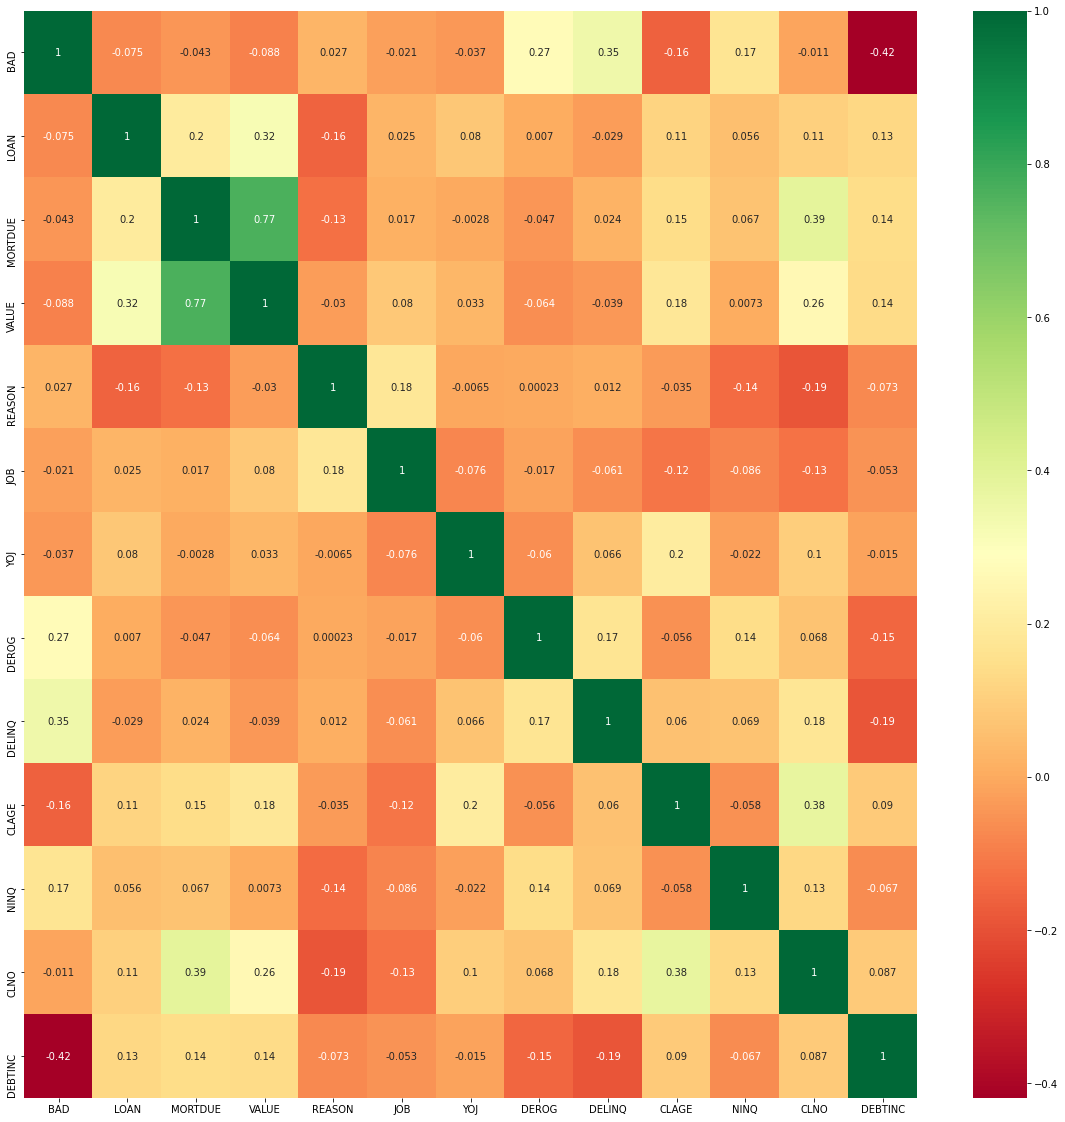

In [43]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index                                    
plt.figure(figsize=(20,20))                                  
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# predictive analysis


many companies still use the traditional model(Logistic or Linear Regression) for deciding their businesses due to their interpretable nature. Recent research and much winning data hackathon solutions show the Gradient Boosting Algorithm(Lightgbm, Catboost, and Xgboost) are more robust than the traditional model.

# FOR THE MODEL PREDICTION, WE WOULD BE USING LIGHTGBM model

 lightGBM is a gradient boosting framework that makes use of tree based learning algorithms that is considered to be a very powerful algorithm when it comes to computation.

It has become difficult for the traditional algorithms to give results fast, as the size of the data is increasing rapidly day by day. LightGBM is called “Light” because of its computation power and giving results faster. It takes less memory to run and is able to deal with large amounts of data. 

LightGBM is not for a small volume of datasets. It can easily overfit small data due to its sensitivity. It can be used for data having more than 10,000+ rows. There is no fixed threshold that helps in deciding the usage of LightGBM. It can be used for large volumes of data especially when one needs to achieve a high accuracy.

In [48]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix,plot_roc_curve
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [49]:
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = -1
    params["num_leaves"] = 10
    params["min_data_in_leaf"] = 20
    params["learning_rate"] = 0.03
    params["bagging_fraction"] = 0.9
    params["feature_fraction"] = 0.35
    params["feature_fraction_seed"] = 20
    params["bagging_freq"] = 10
    params["bagging_seed"] = 30
    params["'min_child_weight'"] = 0.09
    params["lambda_l1"] = 0.01
    params["verbosity"] = -1
from lightgbm import LGBMClassifier # intializing the model
model = LGBMClassifier(**params)
# fitting the model
model.fit(X_train,y_train)

LGBMClassifier("'min_child_weight'"=0.09, bagging_fraction=0.9, bagging_freq=10,
               bagging_seed=30, feature_fraction=0.35, feature_fraction_seed=20,
               lambda_l1=0.01, learning_rate=0.03, metric='auc',
               min_data_in_leaf=20, num_leaves=10, objective='binary',
               verbosity=-1)

In [52]:
y_pred = model.predict(X_test)


In [54]:
print("Testing Accuracy :", model.score(X_test, y_test))
print("Training Accuracy :", model.score(X_train,y_train))

Testing Accuracy : 0.8766778523489933
Training Accuracy : 0.8938758389261745


In [55]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred = [ 1 if y>=0.5 else 0 for y in Y_pred]

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
print(cm)

[[950  10]
 [137  95]]


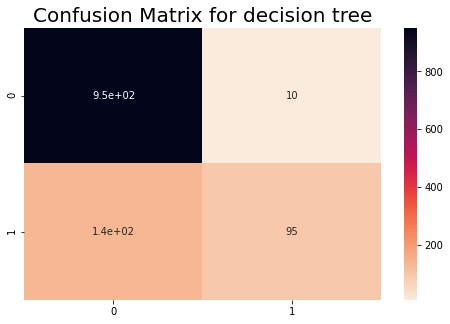

In [57]:
# plottinhg the confusion matrix

plt.rcParams['figure.figsize'] = (8, 5)
sns.heatmap(cm, annot = True, cmap = 'rocket_r')
plt.title('Confusion Matrix for decision tree', fontweight = 30, fontsize = 20)
plt.show()

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       960
           1       0.90      0.41      0.56       232

    accuracy                           0.88      1192
   macro avg       0.89      0.70      0.75      1192
weighted avg       0.88      0.88      0.86      1192



In [59]:
LGB_y_prob = model.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(LGB_y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(X_test, y_pred)

1.0

In [61]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, LGB_y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9265849497126437

Text(0.5, 0, 'False Positive Rate')

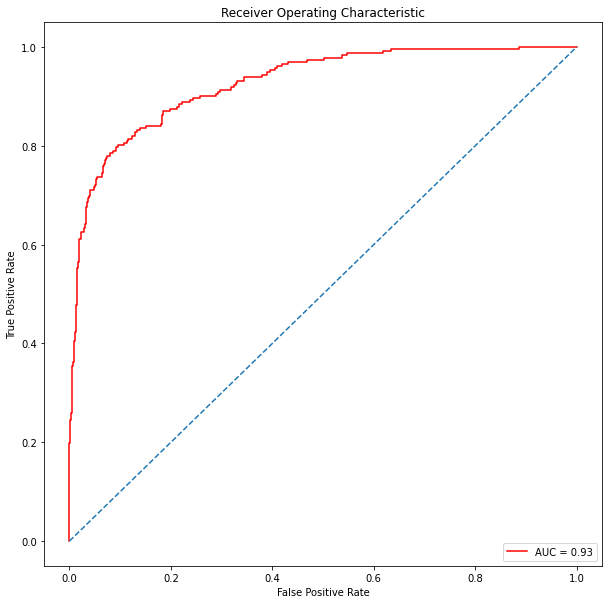

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# MODEL EXPLAINABILITY / INTERPRETABILITY
What is explainable AI?
Explainable AI methods, such as LIME, allow to explain and interpret the predictions of machine learning models. They offer a solution for the trade-off between interpretability and performance, i. e. between complex models that can handle large and versatile data sets and less complex models that are much easier to interpret, but usually also less performant.

In short, they provide insight into the criteria behind predictions of machine learning models.

Interpretability delineates the passive feature of a learning model referring to the extent at which a given learning model makes sense to a user.
Explainability is an active feature of a learning model describing the processes undertaken by the learning model with the intent of clarifying the inner working of the learning model. It is related to the notion of an argument or explanation where there is an interface between the user and the decision-maker.

# ELI5 Model Interpretation
According to their documentation, ELI5 ("Explain Like I'm 5") is a Python library which helps to debug machine learning classifiers and regressors and explain their predictions in an easy to understand an intuitive way. ELI5 is a good starting point and support tree-based and parametric/linear models and also text processing and HashingVectorizer utilities from scikit-learn but doesn't support true model-agnostic interpretations.

In [78]:
,./import eli5
from eli5.sklearn import PermutationImportance

In [86]:
target = 'BAD'
features_list = list(data.columns)
features_list.remove(target)

In [89]:
#best features are arrange from top to the least important feature

eli5.show_weights(model, feature_names=features_list)


Weight,Feature
0.4360,DEBTINC
0.1816,DELINQ
0.0672,VALUE
0.0562,DEROG
0.0545,CLAGE
0.0390,CLNO
0.0389,YOJ
0.0384,LOAN
0.0314,NINQ
0.0301,MORTDUE


In [90]:
eli5.show_prediction(model, X_test.iloc[i], feature_names=features_list, show_feature_values=True)

# SHAP MODEL EXPLAINABILITY

SHAP stands for SHapley Additive exPlanations. The core idea behind Shapley value-based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model’s output f(x)f(x) among its input features. In order to connect game theory with machine learning models it is necessary to both match a model’s input features with players in a game, and also match the model function with the rules of the game.

In [133]:
from xgboost import XGBClassifier

models = XGBClassifier(random_state=42)
models.fit(X_train, y_train)
score = models.score(X_test, y_test)

[16:31:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [134]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [135]:
#initiate Javascript
shap.initjs()

# Explaining single prediction with shap
With SHAP, we can generate explanations for a single prediction. The SHAP plot shows features that contribute to pushing the output from the base value (average model output) to the actual predicted value.

In [136]:
#Red color indicates features that are pushing the prediction higher, and blue color indicates just the opposite

shap.force_plot(explainer.expected_value, shap_values[7, :], X.iloc[7, :])

In [137]:
shap.force_plot(explainer.expected_value, shap_values[3, :], X.iloc[3, :])

In [141]:
shap.force_plot(explainer.expected_value, shap_values[1, :], X.iloc[1, :])

# Explaining single feature
To understand the effect a single feature has on the model output, we can plot a SHAP value of that feature vs. the value of the feature for all instances in the dataset.

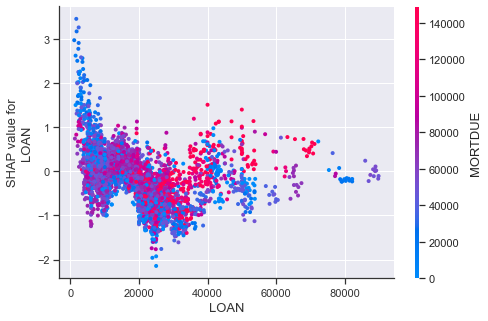

In [142]:
shap.dependence_plot('LOAN', shap_values, X)

# Let’s now examine the entire dataset to determine which features are most important for the model and how they contribute to the predictions.

# Explaining the entire dataset
We can visualize the importance of the features and their impact on the prediction by plotting summary charts. The one below sorts features by the sum of SHAP value magnitudes over all samples. It also uses SHAP values to show the distribution of the impacts each feature has.

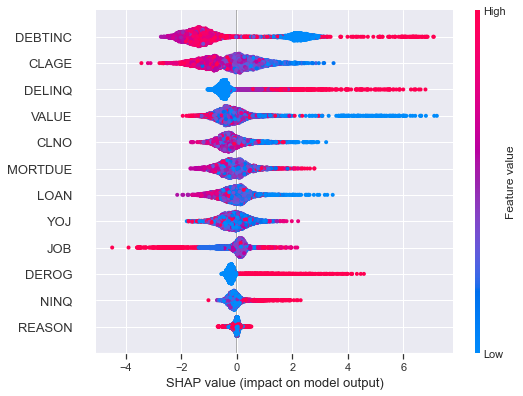

In [143]:
#The color represents the feature value — red indicating high and blue indicating low

shap.summary_plot(shap_values, X)

# lime model interpretability

The explainable AI method LIME (Local Interpretable Model-agnostic Explanations) helps to illuminate a machine learning model and to make its predictions individually comprehensible. The method explains the classifier for a specific single instance and is therefore suitable for local explanations.

In [111]:
from lime.lime_tabular import LimeTabularExplainer


In [112]:
features_list = list(data.columns)


In [113]:

#instantiate the explanations for the data set
limeexplainer = LimeTabularExplainer(X_test.values, 
                                     class_names=['Will pay','Will not pay'], feature_names = X_test.columns, discretize_continuous = True)
idx=1 # the rows of the dataset
explainable_exp = limeexplainer.explain_instance(X_test.values[idx], model.predict_proba, num_features=10, labels=class_names)
explainable_exp.show_in_notebook(show_table=True, show_all=False)

In [116]:
from pdpbox import pdp, get_dataset, info_plots


# Partial Dependence Plots
The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning mode

The library to be used for plotting PDPs is called python partial dependence plot toolbox or simply [PDPbox]. PDPs are also calculated after a model has been fit. In our dataset there are a lot of features like clage, job,clnoe etc. We start by considering a single row.

We proceed by fitting our model and calculating the probability of a person paying a loan which is our target variable.

In [117]:
target = 'BAD'
features_list = list(data.columns)
features_list.remove(target)

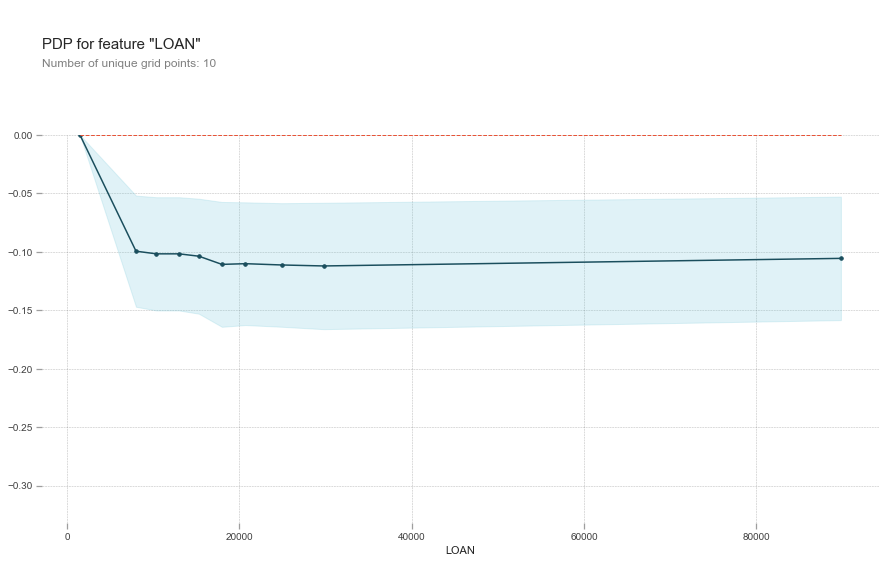

In [119]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features_list, feature='LOAN')

# plot it
pdp.pdp_plot(pdp_goals, 'LOAN')
plt.show()

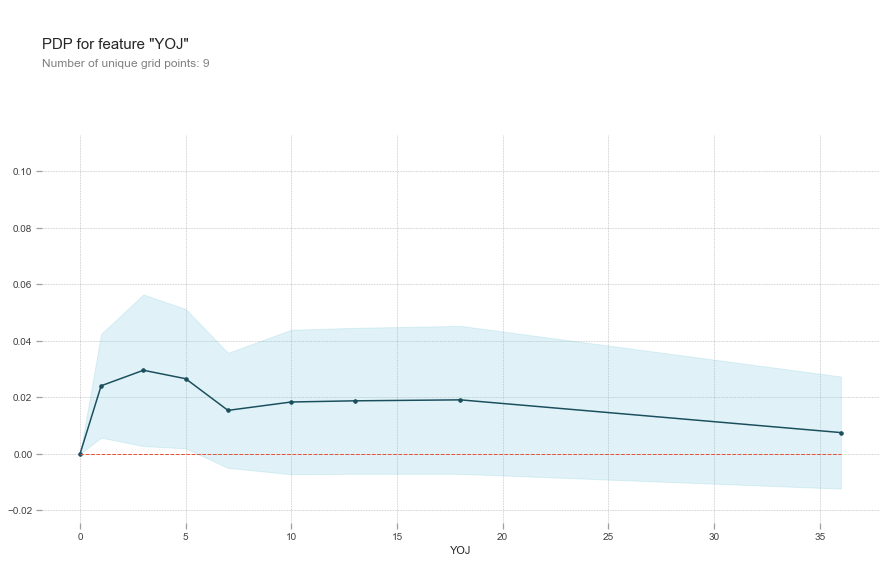

In [125]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features_list, feature='YOJ')

# plot it
pdp.pdp_plot(pdp_goals, 'YOJ')
plt.show()